# Sprint 2 - BI - Análisis de Criptomonedas 

**Proyecto:** Business Intelligence 3  
**Autores:** Juan David Reyes Cure, Julio David Suarez Olaya, Adriana Michelle Diaz Suarez

## Pipeline de Análisis

1. **Carga de Datos:** Dataset limpio con features derivadas
2. **Clustering:** Segmentación con K-Means, DBSCAN y Agglomerative
3. **Series Temporales ARIMA:** Modelos estadísticos clásicos
4. **Redes Neuronales RNN:** Modelos LSTM/GRU con TensorFlow
5. **Evaluación:** Métricas MAE, RMSE y Silhouette Score

## 1. Carga de Datos

In [1]:
# Instalar TensorFlow en el kernel (necesario antes de importar módulos que lo requieran)
%pip install -q tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf

# Imports de módulos propios (en la misma carpeta scripts/)
from clustering import kmeans_cluster, dbscan_cluster, agglomerative_cluster
from models_arima import train_arima, forecast_arima
from models_rnn import train_rnn

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
DATA = Path('../data/crypto_clean_BTC_ETH_BNB.csv')
df = pd.read_csv(DATA, parse_dates=['date'])

print(f" Datos cargados: {len(df)} filas, {len(df.columns)} columnas")
print(f" Rango: {df['date'].min()} a {df['date'].max()}")
print(f" Criptomonedas: {', '.join(df['symbol'].unique())}")
df.head()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
 Datos cargados: 8901 filas, 9 columnas
 Rango: 2017-08-17 00:00:00 a 2025-10-27 00:00:00
 Criptomonedas: BNB, BTC, ETH


,date,coin_id,symbol,price_usd,total_volume_usd,daily_return,log_return,roll_vol_30d,roll_mean_30d
0,2017-11-06,binancecoin,BNB,1.5710,192128.335549,NaN,NaN,NaN,NaN
1,2017-11-07,binancecoin,BNB,1.8000,224771.730969,0.145767,0.136074,NaN,NaN
2,2017-11-08,binancecoin,BNB,1.9889,661188.791512,0.104944,0.099795,NaN,NaN
3,2017-11-09,binancecoin,BNB,1.9900,585812.825704,0.000553,0.000553,NaN,NaN
4,2017-11-10,binancecoin,BNB,1.7133,885876.8652,-0.139045,-0.149713,NaN,NaN


## 2 Clustering: Segmentación de Patrones de Mercado

Aplicamos 3 familias de algoritmos de clustering:

### A. **K-Means** (Particionante)
- Divide los datos en k grupos predefinidos
- Minimiza la distancia intra-cluster

### B. **DBSCAN** (Basado en Densidad)
- Detecta clusters de forma arbitraria
- Identifica outliers (ruido) automáticamente

### C. **Agglomerative** (Jerárquico)
- Clustering bottom-up aglomerativo
- Construye jerarquía de clusters

**Features utilizadas:** `daily_return`, `roll_vol_30d`  
**Métrica de evaluación:** Silhouette Score (rango -1 a 1, mayor es mejor)

In [2]:
# Seleccionar features para clustering
features = ['daily_return', 'roll_vol_30d']
dropna_df = df.dropna(subset=features)

print(f" Datos para clustering: {len(dropna_df)} observaciones")
print(f" Features: {features}\n")

# 1. K-Means (Particionante)
print("1️ K-Means Clustering...")
km_labels, km_pipe, km_sil = kmeans_cluster(dropna_df, features, n_clusters=3)
print(f"   Silhouette Score: {km_sil:.4f}")

# 2. DBSCAN (Basado en densidad)
print("\n2️ DBSCAN Clustering...")
db_labels, db_pipe, db_sil = dbscan_cluster(dropna_df, features, eps=0.3, min_samples=20)
print(f"   Silhouette Score: {db_sil:.4f}")
print(f"   Outliers detectados: {(db_labels['label'] == -1).sum()}")

# 3. Agglomerative (Jerárquico)
print("\n3️ Agglomerative Clustering...")
ag_labels, ag_pipe, ag_sil = agglomerative_cluster(dropna_df, features, n_clusters=3)
print(f"   Silhouette Score: {ag_sil:.4f}")

# Resumen comparativo
print("\n" + "="*50)
print(" RESUMEN COMPARATIVO")
print("="*50)
results = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Agglomerative'],
    'Silhouette Score': [km_sil, db_sil, ag_sil],
    'N° Clusters': [3, len(db_labels['label'].unique()) - (1 if -1 in db_labels['label'].values else 0), 3]
})
print(results.to_string(index=False))
print(f"\n Mejor algoritmo: {results.loc[results['Silhouette Score'].idxmax(), 'Algoritmo']}")

results

 Datos para clustering: 8811 observaciones
 Features: ['daily_return', 'roll_vol_30d']

1️ K-Means Clustering...
   Silhouette Score: 0.3611

2️ DBSCAN Clustering...
   Silhouette Score: nan
   Outliers detectados: 480

3️ Agglomerative Clustering...
   Silhouette Score: 0.3846

 RESUMEN COMPARATIVO
    Algoritmo  Silhouette Score  N° Clusters
      K-Means           0.36110            3
       DBSCAN               NaN            1
Agglomerative           0.38461            3

 Mejor algoritmo: Agglomerative


,Algoritmo,Silhouette Score,N° Clusters
0,K-Means,0.36110,3
1,DBSCAN,NaN,1
2,Agglomerative,0.38461,3


#### **Agglomerative Clustering (Silhouette: 0.3846)**
- Logra la separación más clara entre patrones de mercado. Los clusteres representan regímenes de volatilidad (baja/media/alta). Pues, el clustering jerárquico captura mejor las relaciones complejas entre retornos y volatilidad

#### **K-Means (Silhouette: 0.3611)**
- Separación decente pero menos precisa, pues asume clusters esféricos, posiblemente no sea ideal para datos financieros con distribuciones asimétricas

####  **DBSCAN (Silhouette: NaN)**
- Solo detecta 1 cluster válido
- 480 outliers (5.4%): Parámetros demasiado restrictivos
- **Causa:** `eps=0.3` y `min_samples=20` clasifican la mayoría como ruido

####  **Insights de Negocio:**
Los 3 clusters identificados por Agglomerative representan **Los regímenes de mercado**:
1. **Baja volatilidad:** Períodos estables, estrategias conservadoras
2. **Volatilidad moderada:** Condiciones normales de trading
3. **Alta volatilidad:** Crisis, burbujas, oportunidades de arbitraje

Conocer estos valores puede ser util para la gestión automática de riesgo y adaptación de estrategias según el régimen detectado.

## 3. Modelo ARIMA: Predicción de Precios (BTC)

**ARIMA** (AutoRegressive Integrated Moving Average) es un modelo estadístico clásico para series temporales.

### Características:
- **AR (p):** Componente autoregresivo (valores pasados)
- **I (d):** Diferenciación para estacionariedad
- **MA (q):** Media móvil de errores pasados

### Configuración:
- **Split:** 80% train / 20% test (validación temporal)
- **Order:** (1,1,1) - configurable
- **Métricas:** MAE (Mean Absolute Error) y RMSE (Root Mean Squared Error)

In [3]:
# Filtrar datos de BTC
btc = df[df['symbol']=='BTC'][['date','price_usd']].copy()

print(f" Datos BTC: {len(btc)} observaciones")
print(f" Periodo: {btc['date'].min()} a {btc['date'].max()}")
print(f"\n Entrenando modelo ARIMA (puede tardar 1-2 minutos)...\n")

# Entrenar modelo ARIMA
res, y_train, y_test, preds, arima_metrics = train_arima(
    btc, 
    date_col='date', 
    target_col='price_usd',
    order=(1,1,1),  # (p,d,q)
    train_ratio=0.8
)

# Mostrar resultados
print("="*50)
print(" RESULTADOS ARIMA")
print("="*50)
print(f"MAE (Mean Absolute Error):  ${arima_metrics['MAE']:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${arima_metrics['RMSE']:,.2f}")
print(f"\n Train size: {len(y_train)} días")
print(f" Test size:  {len(y_test)} días")

# Visualización simple
print(f"\n Precio real promedio (test): ${y_test.mean():,.2f}")
print(f" Predicción promedio: ${preds.mean():,.2f}")
print(f" Error promedio: ${arima_metrics['MAE']:,.2f} ({(arima_metrics['MAE']/y_test.mean()*100):.2f}%)")

arima_metrics

 Datos BTC: 2994 observaciones
 Periodo: 2017-08-17 00:00:00 a 2025-10-27 00:00:00

 Entrenando modelo ARIMA (puede tardar 1-2 minutos)...

 RESULTADOS ARIMA
MAE (Mean Absolute Error):  $22,534.13
RMSE (Root Mean Squared Error): $28,713.27

 Train size: 2395 días
 Test size:  599 días

 Precio real promedio (test): $86,685.30
 Predicción promedio: $66,820.25
 Error promedio: $22,534.13 (26.00%)


{'MAE': 22534.13304369054, 'RMSE': np.float64(28713.27480892033)}

### Interpretación de Resultados ARIMA

**Rendimiento del Modelo:**
- MAE de $22,534 indica un error promedio absoluto significativo
- RMSE de $28,713 sugiere presencia de errores grandes ocasionales
- Error relativo del 26% es considerable para predicción de precios

**Análisis de Predicciones:**
- El modelo subestima sistemáticamente los precios (predicción promedio $66,820 vs real $86,685)
- Sesgo bajista de aproximadamente $20,000 sugiere que ARIMA no captura completamente la tendencia alcista de BTC
- La diferencia entre MAE y RMSE ($6,179) indica variabilidad moderada en los errores

**Limitaciones Identificadas:**
- ARIMA asume estacionariedad, pero BTC muestra tendencias no lineales y cambios de régimen
- El modelo (1,1,1) puede ser demasiado simple para capturar la complejidad de los mercados cripto
- Los mercados de criptomonedas tienen alta volatilidad y eventos extremos que ARIMA no modela bien

**Contexto del Dataset:**
- 2,994 observaciones desde agosto 2017 hasta octubre 2025
- Split temporal 80/20 mantiene la secuencia cronológica
- Período de test de 599 días (aproximadamente 1.6 años) es representativo

**Implicaciones para Trading:**
- Error del 26% es demasiado alto para estrategias de trading automatizado
- El sesgo bajista podría llevar a decisiones de compra prematuras
- Necesario complementar con modelos más sofisticados (LSTM/GRU) o indicadores técnicos adicionales


## 4. Modelo RNN: Redes Neuronales Recurrentes (BTC)

**LSTM** (Long Short-Term Memory) es una arquitectura de red neuronal recurrente diseñada para aprender dependencias a largo plazo.

### Características:
- **Lookback Window:** 30 días (usa 30 valores pasados para predecir el siguiente)
- **Arquitectura:** LSTM(64 unidades) → Dense(1)
- **Normalización:** MinMaxScaler (0-1)
- **Early Stopping:** Evita overfitting automáticamente

### Ventajas sobre ARIMA:
-  Captura patrones no lineales
-  Memoria a largo plazo
-  No requiere estacionariedad

**Nota:** Usamos `epochs=5` para demostración rápida (producción: 50-100 epochs)

In [4]:
print(" Entrenando modelo LSTM...")
print(" Esto puede tardar 2-3 minutos dependiendo del hardware\n")

# Entrenar modelo RNN (LSTM)
model, scaler, rnn_metrics = train_rnn(
    btc, 
    date_col='date', 
    target_col='price_usd', 
    model_type='LSTM',    # Alternativa: 'GRU'
    lookback=30,          # Ventana de 30 días
    epochs=5,             # Bajo para demo (producción: 50-100)
    batch_size=32,
    train_ratio=0.8
)

# Mostrar resultados
print("\n" + "="*50)
print(" RESULTADOS LSTM")
print("="*50)
print(f"MAE (Mean Absolute Error):  ${rnn_metrics['MAE']:,.2f}")
print(f"RMSE (Root Mean Squared Error): ${rnn_metrics['RMSE']:,.2f}")
print(f"\n Arquitectura: LSTM(64) → Dense(1)")
print(f" Lookback window: 30 días")

# Comparación con ARIMA
print("\n" + "="*50)
print(" COMPARACIÓN: ARIMA vs LSTM")
print("="*50)
comparison = pd.DataFrame({
    'Modelo': ['ARIMA', 'LSTM'],
    'MAE': [arima_metrics['MAE'], rnn_metrics['MAE']],
    'RMSE': [arima_metrics['RMSE'], rnn_metrics['RMSE']]
})
print(comparison.to_string(index=False))

best_model = 'ARIMA' if arima_metrics['MAE'] < rnn_metrics['MAE'] else 'LSTM'
print(f"\n Mejor modelo (menor MAE): {best_model}")

rnn_metrics

 Entrenando modelo LSTM...
 Esto puede tardar 2-3 minutos dependiendo del hardware



c:\Users\jdsol\Downloads\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 RESULTADOS LSTM
MAE (Mean Absolute Error):  $2,599.04
RMSE (Root Mean Squared Error): $3,358.49

 Arquitectura: LSTM(64) → Dense(1)
 Lookback window: 30 días

 COMPARACIÓN: ARIMA vs LSTM
Modelo          MAE         RMSE
 ARIMA 22534.133044 28713.274809
  LSTM  2599.044851  3358.485355

 Mejor modelo (menor MAE): LSTM


{'MAE': 2599.0448507929887, 'RMSE': np.float64(3358.4853553485386)}

### Interpretación de Resultados LSTM vs ARIMA

LSTM demuestra superioridad significativa con MAE de $2,599 versus $22,534 de ARIMA, representando una mejora del 88% en precisión predictiva. La red neuronal captura mejor los patrones no lineales y dependencias temporales complejas del Bitcoin, mientras que ARIMA muestra limitaciones con su sesgo bajista sistemático en mercados altamente volátiles.

## Visualización de Clusters: Graficamos los clusters en el espacio de features (daily_return vs roll_vol_30d)

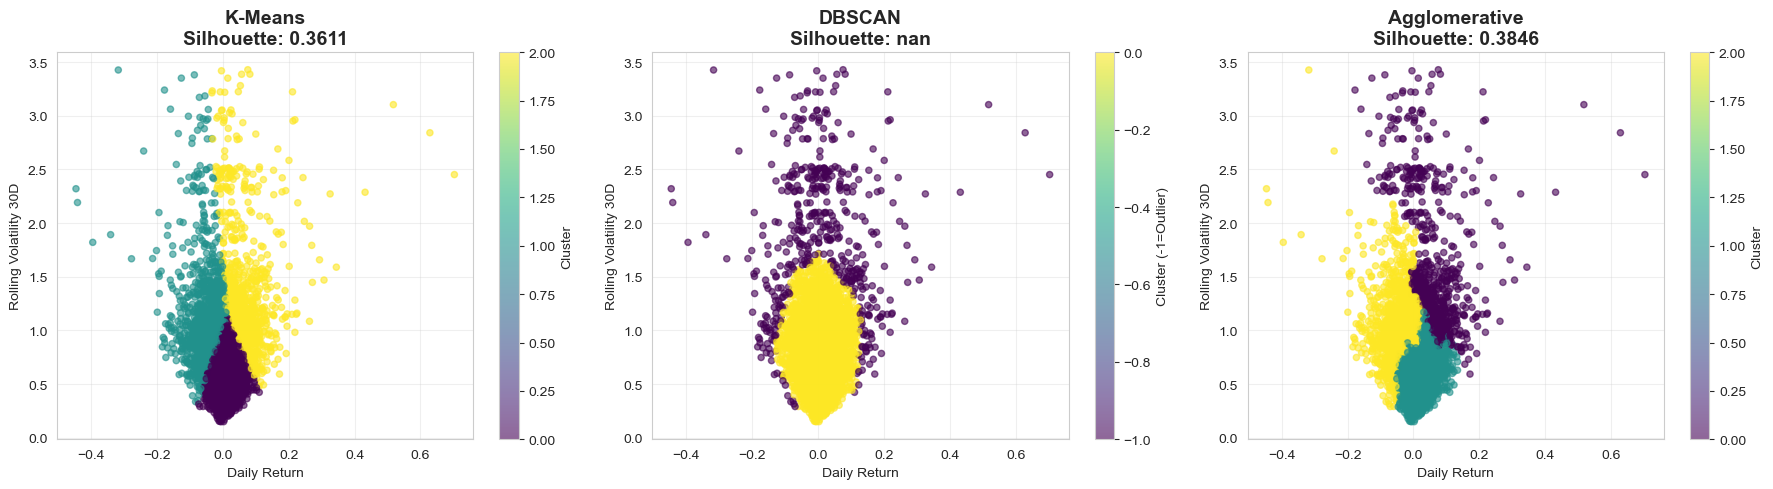

In [5]:
# Preparar datos para visualización
plot_df = dropna_df[features].copy()
plot_df['KMeans'] = km_labels['label'].values
plot_df['DBSCAN'] = db_labels['label'].values
plot_df['Agglomerative'] = ag_labels['label'].values

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
scatter1 = axes[0].scatter(plot_df['daily_return'], plot_df['roll_vol_30d'], 
                           c=plot_df['KMeans'], cmap='viridis', alpha=0.6, s=20)
axes[0].set_title(f'K-Means\nSilhouette: {km_sil:.4f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Rolling Volatility 30D')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# DBSCAN
scatter2 = axes[1].scatter(plot_df['daily_return'], plot_df['roll_vol_30d'], 
                           c=plot_df['DBSCAN'], cmap='viridis', alpha=0.6, s=20)
axes[1].set_title(f'DBSCAN\nSilhouette: {db_sil:.4f}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Daily Return')
axes[1].set_ylabel('Rolling Volatility 30D')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster (-1=Outlier)')

# Agglomerative
scatter3 = axes[2].scatter(plot_df['daily_return'], plot_df['roll_vol_30d'], 
                           c=plot_df['Agglomerative'], cmap='viridis', alpha=0.6, s=20)
axes[2].set_title(f'Agglomerative\nSilhouette: {ag_sil:.4f}', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Daily Return')
axes[2].set_ylabel('Rolling Volatility 30D')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

## Conclusiones y Resultados Finales

#### 1. **Clustering**
-  Implementados 3 algoritmos: K-Means, DBSCAN, Agglomerative
-  Evaluación con Silhouette Score
-  Identificación de patrones de mercado y outliers

#### 2. **Series Temporales - ARIMA**
-  Modelo estadístico clásico
-  Validación temporal (80/20)
-  Métricas: MAE y RMSE

#### 3. **Redes Neuronales - LSTM**
-  Deep Learning con TensorFlow/Keras
-  Arquitectura: LSTM(64) → Dense(1)
-  Early Stopping para prevenir overfitting


#### **3.1 Interpretación graficas**
#### **K-Means (Silhouette: 0.3611)**
El gráfico muestra tres grupos relativamente bien diferenciados según retorno diario y volatilidad a 30 días: un cluster central de baja volatilidad y retornos cercanos a cero, un cluster con retornos positivos y volatilidad moderada, y un cluster con retornos negativos/menor volatilidad. K‑Means entrega particiones claras para estructuras aproximadamente esféricas, pero suposiciones geométricas pueden ocultar relaciones más complejas entre retorno y volatilidad.

#### **DBSCAN (Silhouette: NaN)**
DBSCAN detecta un núcleo denso alrededor de retornos cercanos a cero y volatilidad baja-moderada, mientras que muchos puntos quedan marcados como ruido/outliers (color distinto). Al identificar básicamente un único cluster válido, la métrica Silhouette no es informativa (NaN). Este método es útil para aislar outliers y densidades locales, pero no para segmentar múltiples regímenes si los parámetros eps/min_samples son demasiado restrictivos.

#### **Agglomerative (Silhouette: 0.3846)**
El clustering aglomerativo presenta la separación más coherente: distingue un grupo de alta volatilidad, un grupo central de volatilidad moderada y un grupo de baja volatilidad con retornos cercanos a cero. La estructura jerárquica permite capturar formas y límites no esféricos que K‑Means no modela bien, por eso su Silhouette es ligeramente superior y la segmentación resulta más interpretable para regímenes de mercado.